#Анализ данных магазина компьютерных игр

Интернет-магазин «Стримчик» продаёт компьютерные игры. Перед нами данные о продажах до 2016 года. Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании в 2017-м.

## Загрузка датасета

Для начала, импортирую необходимые библиотеки.

In [1]:
#импорт библиотек
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import scipy.stats as st

import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
#задание стиля диаграмм
mpl.style.use(['Solarize_Light2'])

Теперь открою предоставленный датасет, сохранив его в переменную data.

In [3]:
data = pd.read_csv('/datasets/games.csv')
data

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


На данном этапе у нас есть 16715 строк, хотя в процессе предобработки их наверняка станет меньше. Датасет хранит в себе информацию об играх, которые продаются в интернет магазине: Название, платформа, год издания, жанр, продажи в различных регионах, рейтинги и возрастное ограничение. Уже сейчас видно, что в данных много пропущенных значений. Также названия столбцов не соответствуют snake_case, что нужно будет поправить.

Ими я займусь в следующем разделе, а пока что проведу проверку явных дубликатов.

In [4]:
data.duplicated().sum()

0

Явных дубликатов в датасете нет. Посмотрим возможные отдельные дубликаты по столбцам: Имя, платформа, год.

In [5]:
data[['Name', 'Platform', 'Year_of_Release']].duplicated().sum()

2

Обнаруженные дубликаты удаляю.

In [6]:
data = data.drop_duplicates(subset=['Name', 'Platform', 'Year_of_Release']).reset_index(drop=True)
data[['Name', 'Platform', 'Year_of_Release']].duplicated().sum()

0

## Предобработка данных

### Названия столбцов

Для удобства, переведу все названия столбцов в snake_case. В данном случае, для этого достаточно будет перевести их в нижний регистр.

In [7]:
data.columns = data.columns.str.lower()
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Как видим, список столбцов теперь весь соответствует стилю snake_case.

### Обработка пропущенных значений

Теперь, когда все столбцы имеют корректное название, можно переходить к самим данным. Подсчитаю, сколько у нас пропусков в каждом столбце:

In [8]:
data.isna().sum()

name                  1
platform              0
year_of_release     269
genre                 1
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8577
user_score         6700
rating             6765
dtype: int64

#### Имя и жанр
Начнём с обработки столбцов с именем и жанром, где всего по два пропущенных значения. Возможно, данные пропуски появились из-за некорректного ввода пользователем: например, он мог ввести название на иностранном языке, символы которого потерялись при загрузке в базу данных.

Поскольку их восстановить невозможно, просто удалю эти строки, чтобы не мешались.

In [9]:
data = data.dropna(subset=['name']).reset_index(drop=True)
data[['name', 'genre']].isna().sum()

name     0
genre    0
dtype: int64

Как видим, из обоих столбцов пропуски исчезли: они были на одних и тех же строках.

#### Дата выпуска

В этом столбце у нас не так много пропущенных значений, и будет лучше всего удалить их, чтобы иметь возможность проводить операции над числами, в том числе конвертировать их из чисел с плавающей точкой в целые.

Пропуски здесь могли появиться как по человеческой ошибке, так и по машинной. Например, при переходе на двухтысячные даты старого формата могли потеряться.

In [10]:
data = data.dropna(subset=['year_of_release']).reset_index(drop=True)
data['year_of_release'].isna().sum()

0



#### Оценка критиков

В этом столбце пропущенные значения могут быть связаны с недостаточным колличеством оценок для определения средней оценки критиков. То же с оценками пользователей.

Поскольку они занимают довольно большой пласт от общего числа данных, я их оставлю.


#### Оценка пользователей

Здесь тоже есть много NaN, но этот параметр я выведа отдельно от остальных из-за того, что он имеет тип object, а не float. Что могло к этому привести? Посмотрим на уникальные значения, чтобы понять.

In [11]:
data['user_score'].sort_values().unique()

array(['0', '0.2', '0.3', '0.5', '0.6', '0.7', '0.9', '1', '1.1', '1.2',
       '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '1.9', '2', '2.1', '2.2',
       '2.3', '2.4', '2.5', '2.6', '2.7', '2.8', '2.9', '3', '3.1', '3.2',
       '3.3', '3.4', '3.5', '3.6', '3.7', '3.8', '3.9', '4', '4.1', '4.2',
       '4.3', '4.4', '4.5', '4.6', '4.7', '4.8', '4.9', '5', '5.1', '5.2',
       '5.3', '5.4', '5.5', '5.6', '5.7', '5.8', '5.9', '6', '6.1', '6.2',
       '6.3', '6.4', '6.5', '6.6', '6.7', '6.8', '6.9', '7', '7.1', '7.2',
       '7.3', '7.4', '7.5', '7.6', '7.7', '7.8', '7.9', '8', '8.1', '8.2',
       '8.3', '8.4', '8.5', '8.6', '8.7', '8.8', '8.9', '9', '9.1', '9.2',
       '9.3', '9.4', '9.5', '9.6', '9.7', 'tbd', nan], dtype=object)

Среди множества чисел у нас затесались не только NaN, но ещё и неизвестная строка 'tbd'. Что бы это значило? Проверим на позиции, в которых стоит такое значение параметра.

In [12]:
data.query('user_score == "tbd"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010.0,Sports,3.45,2.59,0.0,0.66,NaN,tbd,E
300,Namco Museum: 50th Anniversary,PS2,2005.0,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+
516,Zumba Fitness 2,Wii,2011.0,Sports,1.51,1.03,0.0,0.27,NaN,tbd,T
639,uDraw Studio,Wii,2010.0,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E
709,Just Dance Kids,Wii,2010.0,Misc,1.52,0.54,0.0,0.18,NaN,tbd,E
...,...,...,...,...,...,...,...,...,...,...,...
16423,Planet Monsters,GBA,2001.0,Action,0.01,0.00,0.0,0.00,67.0,tbd,E
16425,Bust-A-Move 3000,GC,2003.0,Puzzle,0.01,0.00,0.0,0.00,53.0,tbd,E
16426,Mega Brain Boost,DS,2008.0,Puzzle,0.01,0.00,0.0,0.00,48.0,tbd,E
16432,Plushees,DS,2008.0,Simulation,0.01,0.00,0.0,0.00,NaN,tbd,E


Беглый взгляд на таблицу наводит на мысль, что эти игры могут иметь недостаточно продаж для определения пользовательской оценки. Проверю это, сравнив продажи этого среза с продажами среза без этого значения.

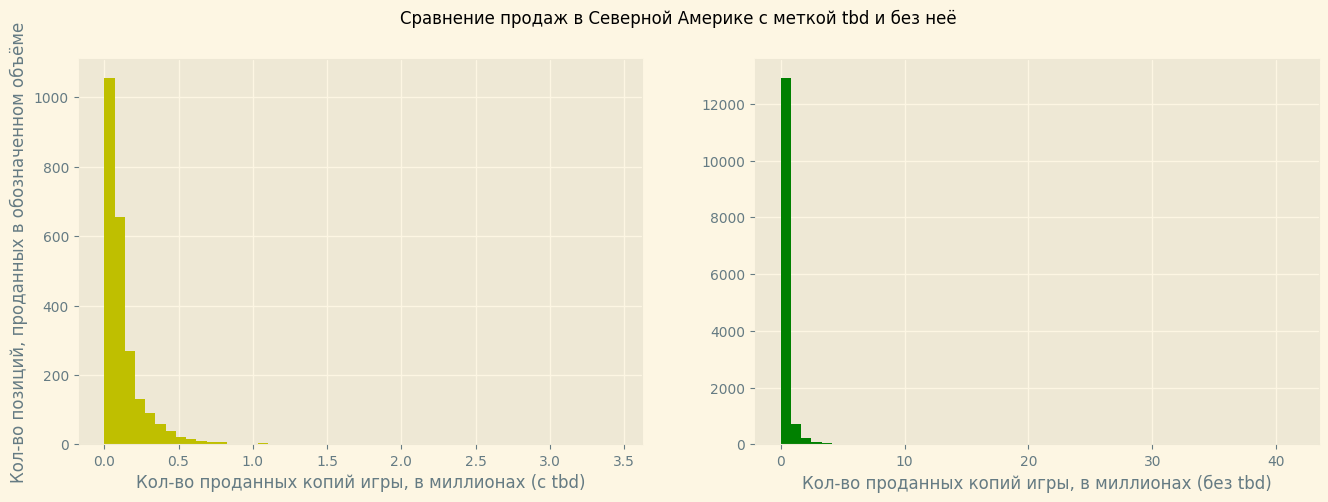

In [13]:
fig, axes = plt.subplots(1,2,figsize=(16,5))
axes[0].hist(data.loc[data['user_score'] == 'tbd', 'na_sales'], bins=50, color='y')
axes[1].hist(data.loc[data['user_score'] != 'tbd', 'na_sales'], bins=50, color='g')
axes[0].set_ylabel('Кол-во позиций, проданных в обозначенном объёме')
axes[0].set_xlabel('Кол-во проданных копий игры, в миллионах (с tbd)')
axes[1].set_xlabel('Кол-во проданных копий игры, в миллионах (без tbd)')
fig.suptitle('Сравнение продаж в Северной Америке с меткой tbd и без неё');

По разбросу по оси x можно сделать вывод, что с "tbd" количество проданных копий игры не более 3,5 миллионов, в то время как без tbd оно уходит за 40 миллионов.

TBD — "To be determined" — переводится как "Будет определено", т.е. эти позиции имеют ещё недостаточно пользовательских оценок, чтобы определить их рейтинг.

Другими словами, tbd в данном случае — это аналог NaN. А потому заменю "tbd" на отсутствующие значения. Это необходимо сделать, чтобы над столбцом в дальнейшем можно было проводить операции с числами.

In [14]:
data.loc[data['user_score'] == 'tbd','user_score'] = np.nan
data['user_score'].sort_values().unique()

array(['0', '0.2', '0.3', '0.5', '0.6', '0.7', '0.9', '1', '1.1', '1.2',
       '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '1.9', '2', '2.1', '2.2',
       '2.3', '2.4', '2.5', '2.6', '2.7', '2.8', '2.9', '3', '3.1', '3.2',
       '3.3', '3.4', '3.5', '3.6', '3.7', '3.8', '3.9', '4', '4.1', '4.2',
       '4.3', '4.4', '4.5', '4.6', '4.7', '4.8', '4.9', '5', '5.1', '5.2',
       '5.3', '5.4', '5.5', '5.6', '5.7', '5.8', '5.9', '6', '6.1', '6.2',
       '6.3', '6.4', '6.5', '6.6', '6.7', '6.8', '6.9', '7', '7.1', '7.2',
       '7.3', '7.4', '7.5', '7.6', '7.7', '7.8', '7.9', '8', '8.1', '8.2',
       '8.3', '8.4', '8.5', '8.6', '8.7', '8.8', '8.9', '9', '9.1', '9.2',
       '9.3', '9.4', '9.5', '9.6', '9.7', nan], dtype=object)

Как видим, теперь среди уникальных значений tbd нет, ведь их все мы заменили на NaN.

#### Возрастной рейтинг

В столбце rating обозначены возрастные рейтинги по ESRB. Скорее всего, пропуски здесь связаны с тем, что организация ещё не определила рейтинг игры. Для пока не определённого рейтинга у них есть отдельная категория RP — Rating Pending. Заменю пропуски на него.

In [15]:
data['rating'] = data['rating'].fillna('RP')
data['rating'].isna().sum()

0

### Изменение типов данных

Посмотрим, к каким типам относятся наши столбцы на данный момент.

In [16]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16443 entries, 0 to 16442
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  float64
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     7982 non-null   float64
 9   user_score       7462 non-null   object 
 10  rating           16443 non-null  object 
dtypes: float64(6), object(5)
memory usage: 5.6 MB


Для начала, не ясно, почему год выпуска представлен типом float64, ведь год не может не быть целочисленным. Также смущает, что user_score относится к object, а не к float.

#### Год выпуска

Заменю год выпуска на int.

In [17]:
data['year_of_release'] = data['year_of_release'].astype('int16')
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,RP
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,RP


Теперь у нас в столбце с годом выпуска года перечислены без точки.

#### Пользовательский рейтинг

Теперь поменяю тип user_score с object на float. Изначально он был object из-за наличия строковых данных в виде "tbd", но теперь не должно возникнуть проблем с его конвертацией.

In [18]:
data['user_score'] = data['user_score'].astype('float64')
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16443 entries, 0 to 16442
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  int16  
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     7982 non-null   float64
 9   user_score       7462 non-null   float64
 10  rating           16443 non-null  object 
dtypes: float64(6), int16(1), object(4)
memory usage: 4.9 MB


Теперь, как и должно быть, у нас год относится к int, а пользовательский рейтинг к float.

#### Оптимизация численных типов

Уменьшу объём памяти, занимаемый числами с плавающей точкой.

In [19]:
cols_to_float = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'critic_score', 'user_score']
for col in cols_to_float:
    data[col] = pd.to_numeric(data[col], downcast='float').round(2)
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16443 entries, 0 to 16442
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  int16  
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float32
 5   eu_sales         16443 non-null  float32
 6   jp_sales         16443 non-null  float32
 7   other_sales      16443 non-null  float32
 8   critic_score     7982 non-null   float32
 9   user_score       7462 non-null   float32
 10  rating           16443 non-null  object 
dtypes: float32(6), int16(1), object(4)
memory usage: 4.5 MB


Как видно по строке memory usage, мы уменьшили объём занимаемой памяти на 0.3 мегабайта, просто понизив разрядность столбцов с типом float.

### Суммарные продажи в регионах

Для удобства создам ещё один столбец, в который суммирую все столбцы с продажами. Назову его total_sales:

In [20]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.360001,28.959999,3.77,8.45,76.0,8.0,E,82.539993
1,Super Mario Bros.,NES,1985,Platform,29.080000,3.580000,6.81,0.77,NaN,NaN,RP,40.240002
2,Mario Kart Wii,Wii,2008,Racing,15.680000,12.760000,3.79,3.29,82.0,8.3,E,35.520000
3,Wii Sports Resort,Wii,2009,Sports,15.610000,10.930000,3.28,2.95,80.0,8.0,E,32.770000
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.270000,8.890000,10.22,1.00,NaN,NaN,RP,31.380001


Столбец был успешно создан.

### Промежуточный вывод

В разделе предобработки данных я:
- Перевела названия столбцов в общепринятый стиль snake_case;
- Обработала пропуски: удалила строки с пропущенными значениями в столбцах "имя" и "год выпуска", оставила в "продажах";
- Изменила типы данных в столбцах "год выпуска" и "оценка пользователей", оптимизировала численные типы данных;
- Создала новый столбец, собравший в себя продажи из всех регионов.

## Исследовательский анализ данных

### Сколько игр выпускалось за разные годы

Посмотрю, сколько игр выходило в каждый из имеющихся в таблице годов и оценю, настолько ли все годы нам интересны. Для этого построю гистограмму:

Минимум = 1980 
Максимум = 2016


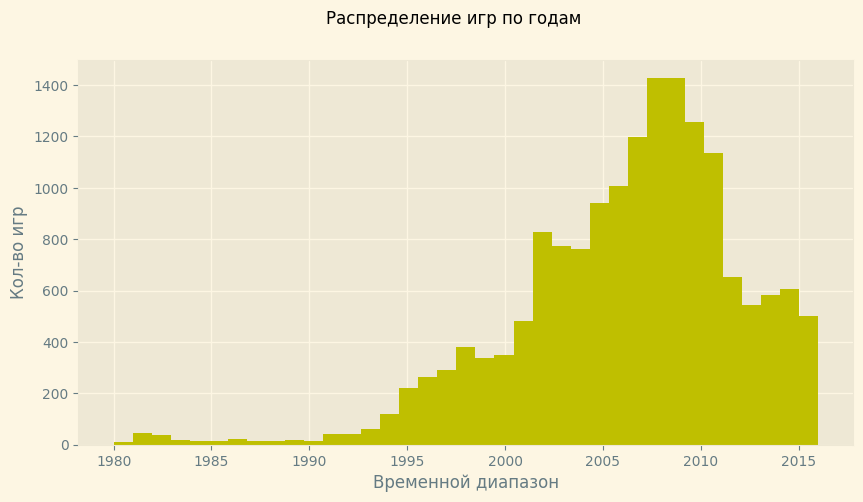

In [21]:
fig, axes = plt.subplots(1,figsize=(10,5))
axes.hist(data['year_of_release'], bins=37, color='y')
fig.suptitle('Распределение игр по годам');
axes.set_ylabel('Кол-во игр')
axes.set_xlabel('Временной диапазон')
print ('Минимум =', data['year_of_release'].min(), '\nМаксимум =', data['year_of_release'].max())

Как видно, игр, выпущенных до 1990 года представлено совсем уж мало.

### Анализ игровых платформ

В данном подразделе посмотрим, какие в нашей выборке есть платформы, когда и какие из них были популярны. Составлю список из 10 самых популярных платформ и посмотрю, как менялось количество выпускаемых на них игр на протяжении лет.

In [22]:
platform_pivot = data.pivot_table(index='platform', values='total_sales', aggfunc='sum')
platform_pivot = platform_pivot.sort_values(by='total_sales', ascending=False).head(10)
top_platforms = platform_pivot.index
platform_pivot

,total_sales
platform,
PS2,1233.559937
X360,961.239990
PS3,931.330017
Wii,891.179993
DS,802.780029
PS,727.580017
PS4,314.140015
GBA,312.880005
PSP,289.529999


Выше у нас список из самых популярных платформ. По ним составим диаграммы: в оси x будут годы, а в оси y — число проданных игр.

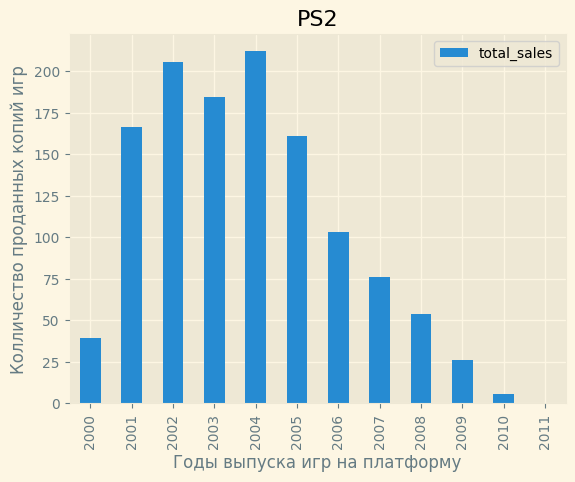

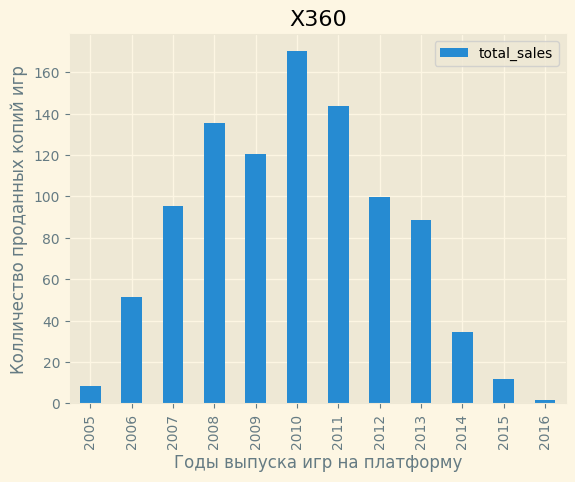

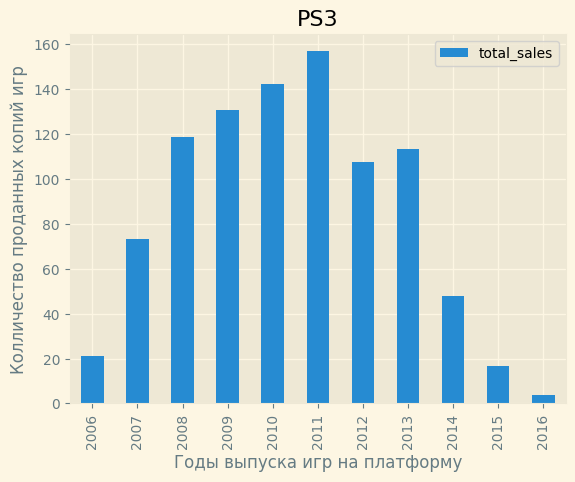

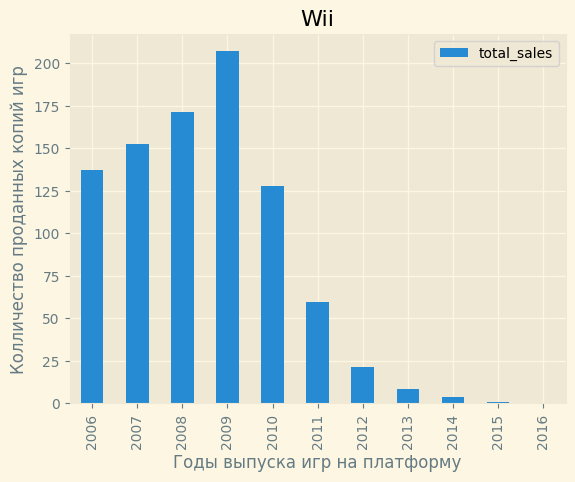

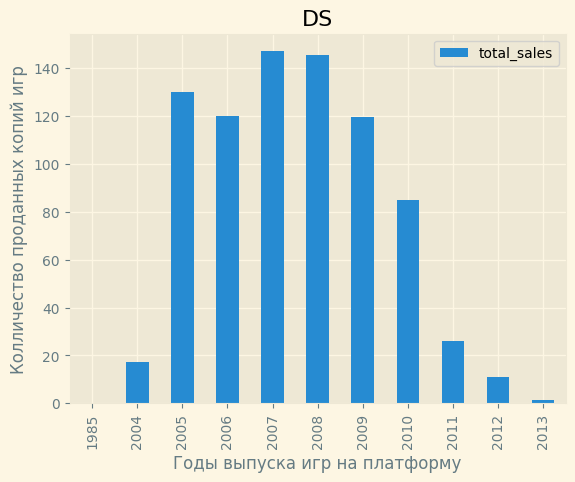

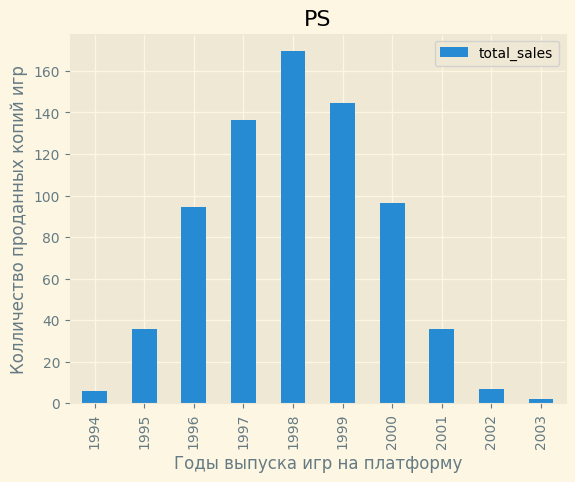

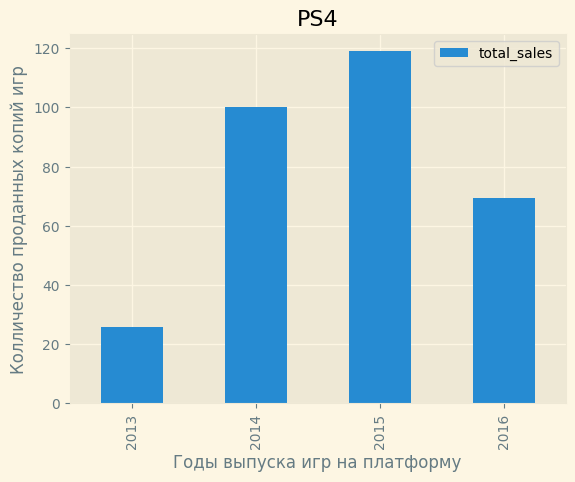

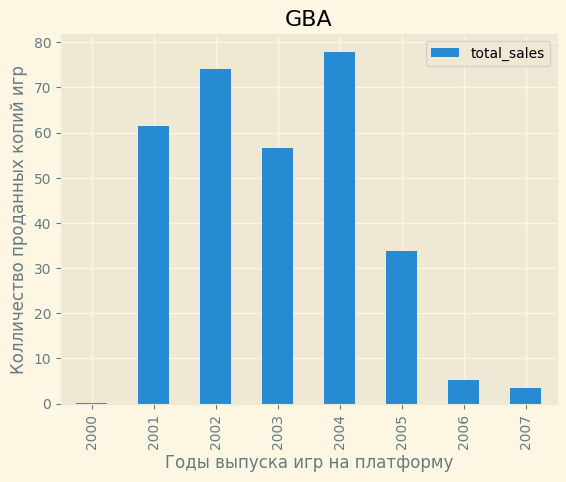

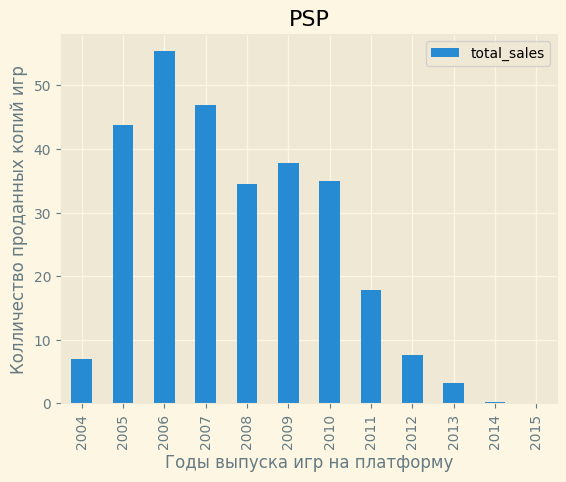

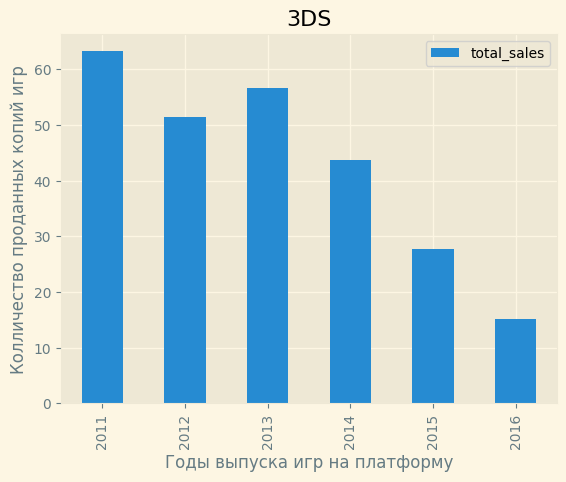

In [23]:
for platform in top_platforms:
    data.query('platform == @platform').pivot_table(index='year_of_release',
                                                    values='total_sales',
                                                    aggfunc='sum').plot(y='total_sales',
                                                                        kind='bar', grid=True,
                                                                        title=platform,
                                                                        xlabel='Годы выпуска игр на платформу',
                                                                        ylabel='Колличество проданных копий игр')

У нас получилось множество любопытных графиков. Мы видим, что более продающиеся платформы отличаются дольшим сроком жизни. Из этого, конечно, есть свои исключения: например, продажи на платформе PSP не поднимались выше 60 миллионов за год, но прожила платформа около десяти лет.

Также видно небольшое выпадающее значение лет на графике платформы DS. 1985, при остальных годах от 2004 до 2013. Это явная ошибка в данных, и её стоит удалить.

In [24]:
data = data.loc[(data['platform'] != 'DS') & (data['year_of_release'] != 1985)]

In [25]:
lifespan = data.pivot_table(index='platform', values='year_of_release', aggfunc=['min', 'max'])
lifespan['span'] = lifespan['max'] - lifespan['min'] + 1
lifespan['span'].median()

7.0

Как видно, медианное значение срока жизни — 7 лет, и бОльшая часть платформ будет жить приблизительно столько.

Посмотрим, что будет если посчитать медианное значение только для платформ из топа-10:

In [26]:
lifespan_top = data.query('platform in @top_platforms').pivot_table(index='platform',
                                                                    values='year_of_release',
                                                                    aggfunc=['min', 'max'])
lifespan_top['span'] = lifespan_top['max'] - lifespan_top['min'] + 1
lifespan_top['span'].median()

11.0

Медианное значение здесь становится 11, что явно значительно выше общих семи лет. Это косвенно подтверждает мои слова про связь популярности платформы и её срока жизни: чем более платформа востребована, тем дольше она продолжает существование.

### Актуальный период

Необходимо вычислить, какие данные за какие годы относятся к актуальному периоду. Основной фактор — они должны помочь в составлении прогнозов на 2017 год.

Для актуальности, стоит брать период не более пяти лет. Повторно построим на гистограмму распределения игр по годам из п.п. 3.1 чтобы решить, какой промежуток нам подойдёт:

Text(0.5, 0, 'Временной диапазон')

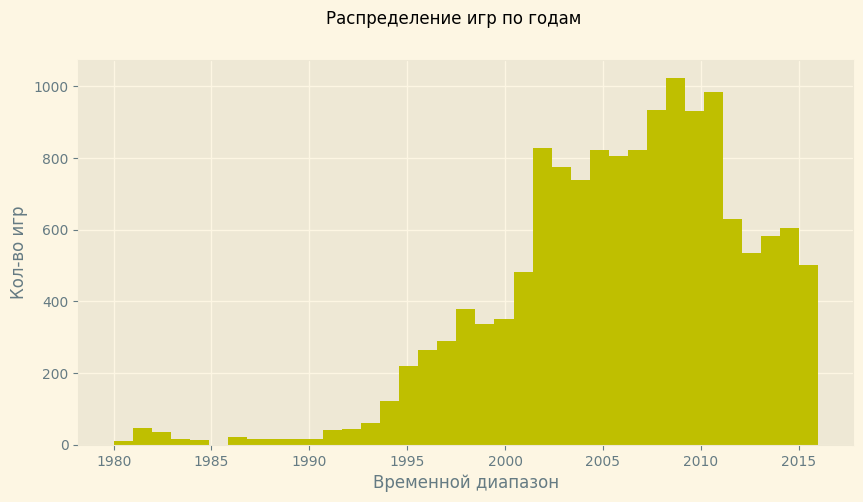

In [27]:
fig, axes = plt.subplots(1,figsize=(10,5))
axes.hist(data['year_of_release'], bins=37, color='y')
fig.suptitle('Распределение игр по годам');
axes.set_ylabel('Кол-во игр')
axes.set_xlabel('Временной диапазон')

По графику сильно бросается в глаза падение числа выпускаемых игр после 2011-го года. Подъём начинается только с 2013. Возьмём этот год за нижнюю границу для нашего нового датасета.

In [28]:
current_data = data.query('year_of_release >= 2013')
print('Размеры изначального датафрейма:', data.shape,
      '\nРазмеры текущего датафрейма:', current_data.shape,
      '\nРазница:', data.shape[0] - current_data.shape[0])

Размеры изначального датафрейма: (14309, 12) 
Размеры текущего датафрейма: (2225, 12) 
Разница: 12084


Мы отрезали 12084 игры, которые были выпущены слишком рано и могли бы негативно повлиять на результаты прогнозирования.

### Потенциально прибыльные платформы

Определим, какие в целом актуальные платформы существуют на момент 2016 года. Для этого возьмём срез данных за 2016 год, посмотрим, какие в нём записаны платформы и составим для них графики, аналогичные сделанным в п.п. 3.2.

In [29]:
data2016 = current_data.query('year_of_release == 2016')
data2016['platform'].unique()

array(['PS4', '3DS', 'XOne', 'WiiU', 'PS3', 'PC', 'X360', 'PSV', 'Wii'],
      dtype=object)

В выводе ячейки выше у нас список из 9 платформ, по которым есть игры, выпущенные в 2016 году.

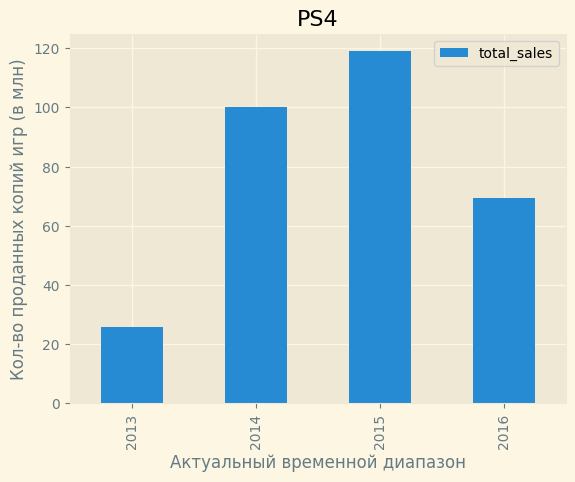

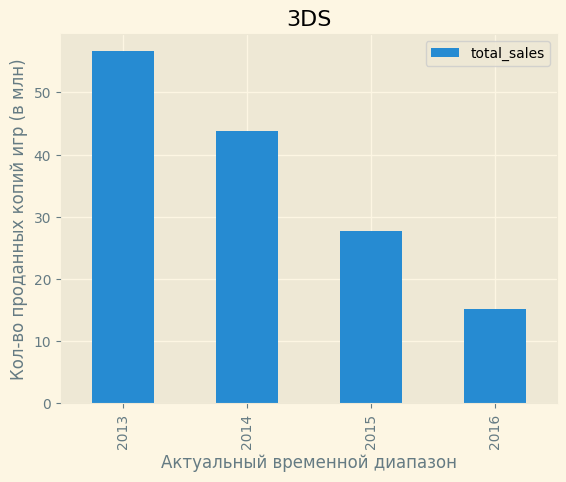

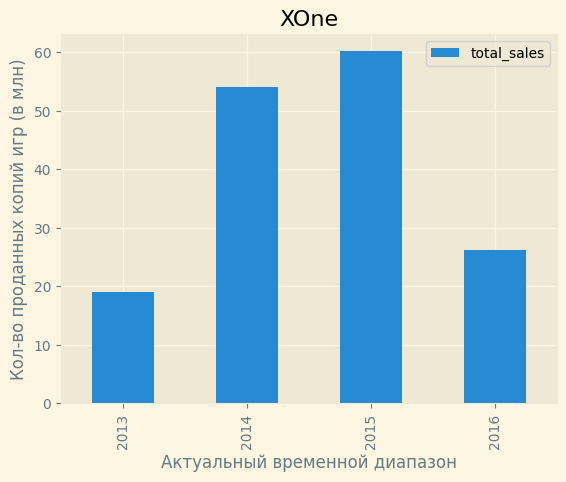

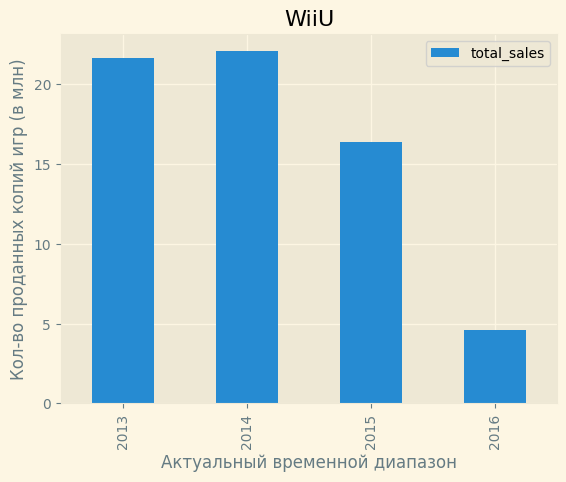

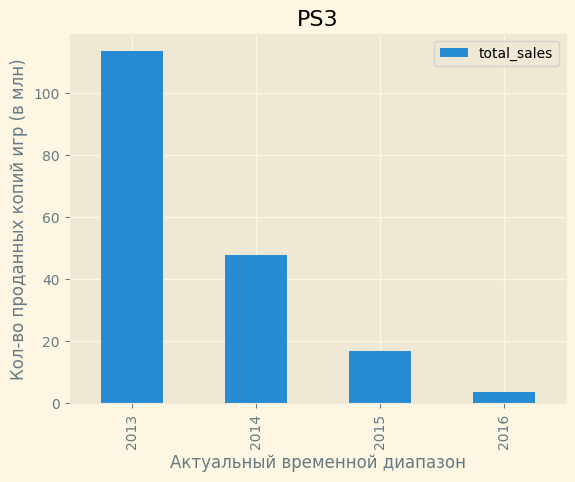

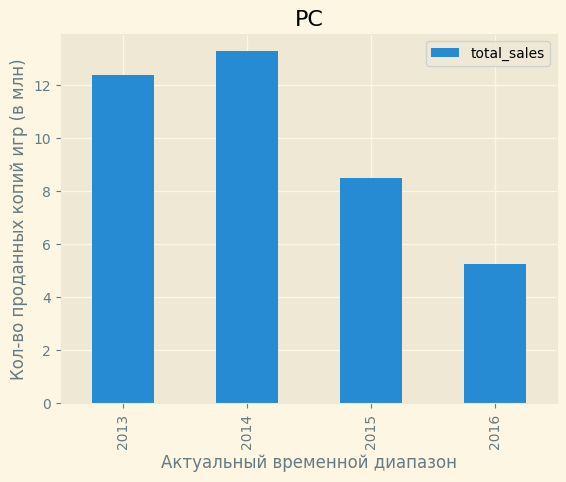

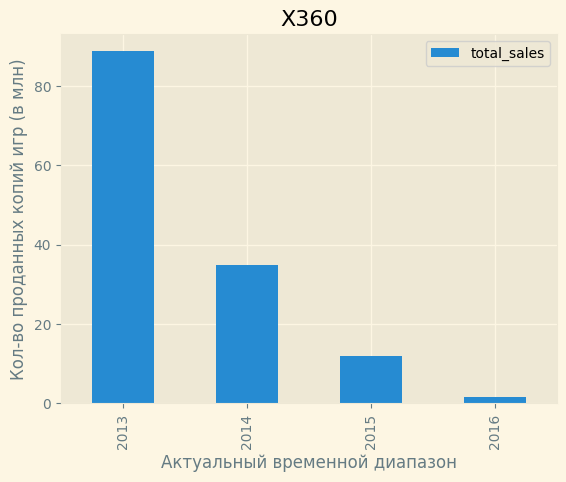

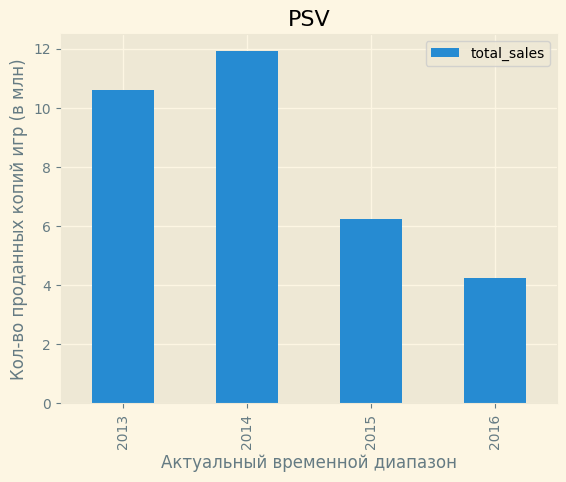

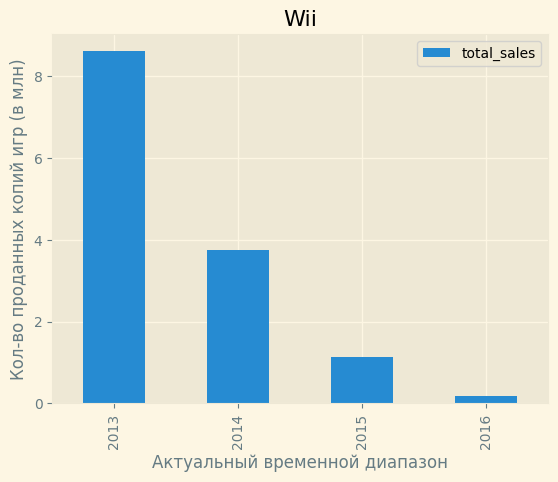

In [30]:
for platform in data2016['platform'].unique():
    current_data.query('platform == @platform').pivot_table(
        index='year_of_release', values='total_sales', aggfunc='sum').plot(
        y='total_sales', kind='bar', grid=True, title=platform,
        xlabel='Актуальный временной диапазон', ylabel='Кол-во проданных копий игр (в млн)')

Теперь можно визуально определить, насколько каждая из этих девяти платформ действительно перспективна в 2017 году.

По PS4, 3DS, XOne, WiiU, PC, PSV видно, что все они уже перешагнули свои пиковые значения продаж, но всё же находятся ещё не настолько по своим диаграммам на момент 2016 года, чтобы говорить, что в 2017 для них не будет создаваться новых игр.

А вот PS3, X360 и Wii с высокой вероятностью полностью исчезнут в грядущем году.

### "Ящик с усами"

Boxplot — он же "ящик с усами" — это вид графика, отображающий медианное значение, отходящие от него квартили и "усы" приемлемых значений. Корректно работает только при приближённом к нормальному распределении, поскольку при нескольких удалённых друг от друга модах будет причислять к выбросам значения, которые на самом деле являются популярными.

Построю график boxplot для тех платформ, которые я для себя определила в предыдущем пункте. Подсчёты буду производить на столбце total_sales, отражающем продажи игры по всем континентам.

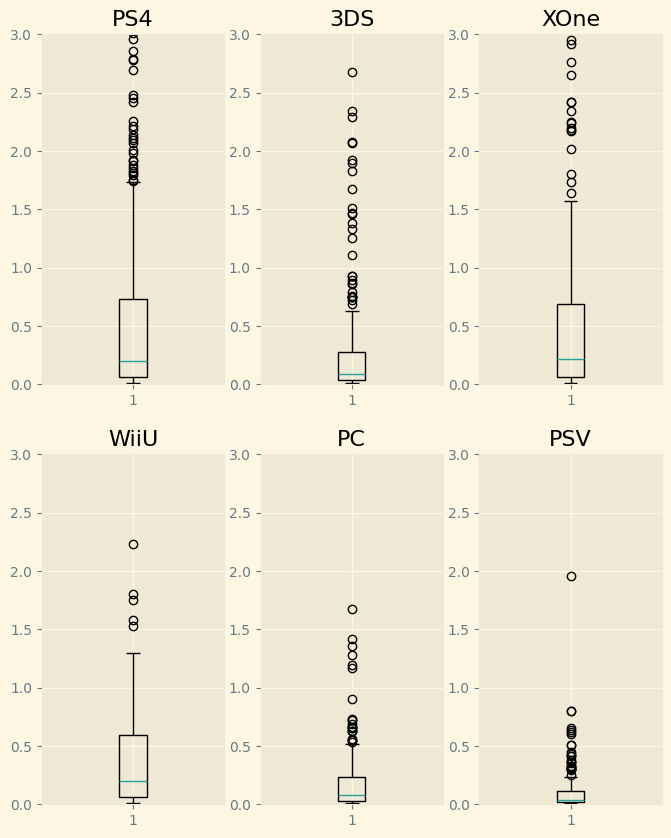

In [31]:
current_platforms = ['PS4', '3DS', 'XOne', 'WiiU', 'PC', 'PSV'] # список названий потенциально прибыльных платформ из п.п. 3.4

fig, axes = plt.subplots(2, 3, figsize=(8, 10))

axes[0,0].boxplot(current_data.query('platform == "PS4"')['total_sales'])
axes[0,0].set_title('PS4')
axes[0,1].boxplot(current_data.query('platform == "3DS"')['total_sales'])
axes[0,1].set_title('3DS')
axes[0,2].boxplot(current_data.query('platform == "XOne"')['total_sales'])
axes[0,2].set_title('XOne')
axes[1,0].boxplot(current_data.query('platform == "WiiU"')['total_sales'])
axes[1,0].set_title('WiiU')
axes[1,1].boxplot(current_data.query('platform == "PC"')['total_sales'])
axes[1,1].set_title('PC')
axes[1,2].boxplot(current_data.query('platform == "PSV"')['total_sales'])
axes[1,2].set_title('PSV')
for ax in axes.flatten():
    ax.set_ylim(0, 3)
plt.show()

Что я вижу на графиках выше:
- Наибольший разброс количества продаж у PS4 и 3DS: до 15 млн копий;
- Меньше всего продаются игры на PSV: самая популярная игра имеет не более 1 млн копий;
- "Ящики" они же — межквартильные размахи, у 3DS и PC самые сжатые: это говорит о высокой концентрации игр, имеющих количество продаж около медианного значения. В данном случае можно сказать, что игр на этих платформах много, но продаются они не так активно;
- На всех платформах существуют свои лидеры, сильно выделяющиеся большими продажами на фоне общей массы игр;
- Этих лидеров, которые выходят за верхний ус, на WiiU практически нет по сравнению с остальными платформами в текущей выборке.

### Корреляция между отзывами и продажами

Для определения корреляции выберу те игры, которые были выпущены для PS4, поскольку платформа достаточно популярная и свежая.

Построю график рассеяния, который будет отражать корреляцию продаж от пользовательских оценок:

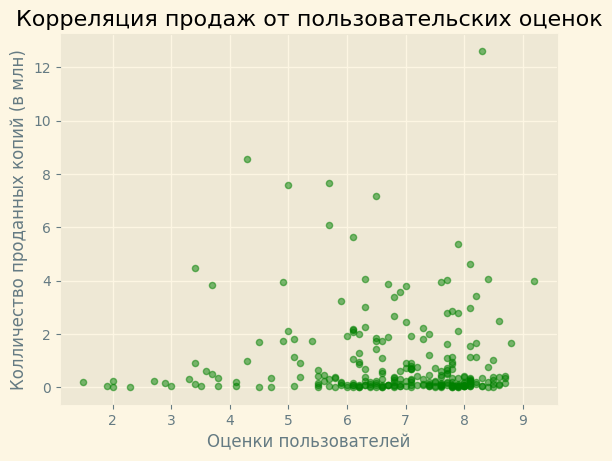

In [32]:
current_data.query('platform == "PS4"').plot(x='user_score',
                                             y='total_sales',
                                             kind='scatter',
                                             color='g', alpha=0.5,
                                             grid=True,
                                             title='Корреляция продаж от пользовательских оценок',
                                             xlabel='Оценки пользователей',
                                             ylabel='Колличество проданных копий (в млн)');

Визуально похоже, что зависимость очень слабая из-за скопления большей части точек внизу, но положительная: больших продаж среди игр с низкими оценками не наблюдается. Рассчитаем корреляцию Пирсона математически:

In [33]:
current_data.query('platform == "PS4"')[['user_score', 'total_sales']].corr()

,user_score,total_sales
user_score,1.000000,-0.031957
total_sales,-0.031957,1.000000


Корреляция -0.03 — это слабая отрицательная корреляция, которая практически близка к нулю.

Теперь произведём всё то же самое, но только с оценками со стороны критиков:

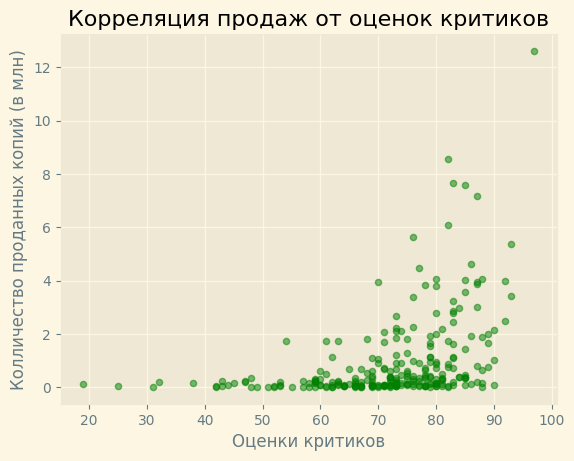

In [34]:
current_data.query('platform == "PS4"').plot(x='critic_score',
                                             y='total_sales',
                                             kind='scatter',
                                             color='g', alpha=0.5,
                                             grid=True,
                                             title='Корреляция продаж от оценок критиков',
                                             xlabel='Оценки критиков',
                                             ylabel='Колличество проданных копий (в млн)');

В этом графике уже заметна волна с районе высоких оценок, а значит, и значение корреляции должно быть выше, даже с всё таким же скоплением точек в районе нулевой отметки. Узнаем наверняка:

In [35]:
current_data.query('platform == "PS4"')[['critic_score', 'total_sales']].corr()

,critic_score,total_sales
critic_score,1.000000,0.406568
total_sales,0.406568,1.000000


И действительно, 0.4 заметно больше, чем -0.03. Корреляция не сильная, но она присутствует: пользователь с наибольшей вероятностью купит игру, если прочитает положительную рецензию на неё.

Таким образом, можно сделать следующие выводы:
- Отзывы пользователей почти влияют на продажи игр;
- Оценки критиков влияют, но не сильно.

### Сравнение с другими платформами

Сравню полученную корреляцию с таковыми на других актуальных платформах: 3DS, XOne, WiiU, PC, PSV. Построю для каждой из них графики рассеяния по аналогии, как делала это для PS4.


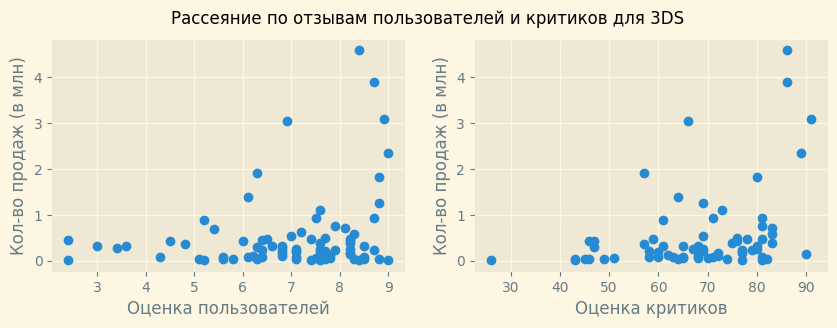

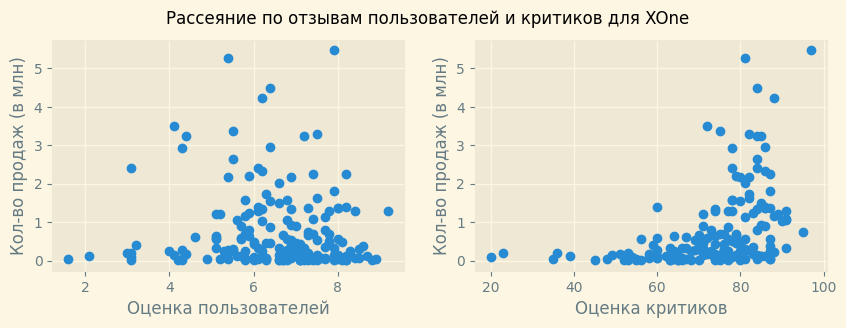

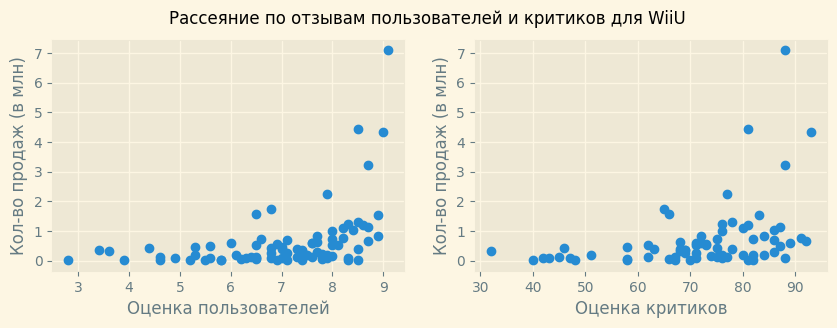

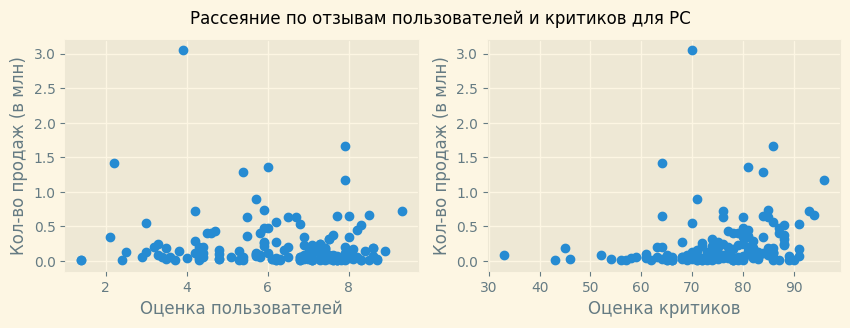

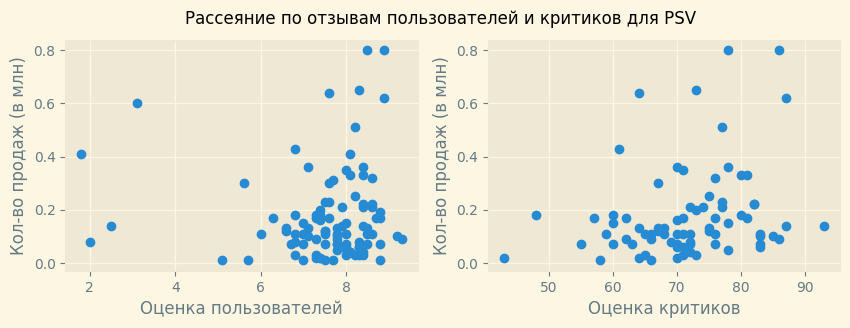

In [36]:
for platform in ['3DS', 'XOne', 'WiiU', 'PC', 'PSV']:
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    ax1 = axes[0]
    ax1.scatter(current_data.query('platform == @platform')['user_score'],
             current_data.query('platform == @platform')['total_sales'])
    ax1.set_xlabel('Оценка пользователей')
    ax1.set_ylabel('Кол-во продаж (в млн)')
    ax2 = axes[1]
    ax2.scatter(current_data.query('platform == @platform')['critic_score'],
             current_data.query('platform == @platform')['total_sales'])
    ax2.set_xlabel('Оценка критиков')
    ax2.set_ylabel('Кол-во продаж (в млн)')
    fig.suptitle(f'Рассеяние по отзывам пользователей и критиков для {platform}')

В целом, по графиккам довольно очевидно наличие слабой корреляции по оценкам. При этом графики с оценкой критиков выглядят более загнутыми, их корреляция немного сильнее, чем с оценкой пользователей.

In [37]:
for platform in ['3DS', 'XOne', 'WiiU', 'PC', 'PSV']:
    print(platform)
    print('Влияние пользовательской оценки:',
          current_data.query('platform == @platform')['user_score'].corr(current_data.query('platform == @platform')['total_sales']))
    print('Влияние оценки критиков:',
          current_data.query('platform == @platform')['critic_score'].corr(current_data.query('platform == @platform')['total_sales']))

3DS
Влияние пользовательской оценки: 0.24150410485682997
Влияние оценки критиков: 0.3570566231203626
XOne
Влияние пользовательской оценки: -0.06892505829722281
Влияние оценки критиков: 0.41699832684400107
WiiU
Влияние пользовательской оценки: 0.4193304905451974
Влияние оценки критиков: 0.37641490703851044
PC
Влияние пользовательской оценки: -0.09384186864546114
Влияние оценки критиков: 0.19603028036502806
PSV
Влияние пользовательской оценки: 0.0009424340644734666
Влияние оценки критиков: 0.25474235289791175


В целом, картина по всем платформам выглядит более-менее похоже: отсутствие корреляции с пользовательскими оценками и слабая корреляция с оценками критиков. Исключение составляет только WiiU, для которой достаточно существенная корреляция присутствует и для пользовательских отметок.

### Распределение игр по жанрам

В этом подразделе я выясню, есть ли зависимость между жанром игры и её продажами.

Построю гистограмму для всех представленных жанров, которая будет отражать количество игр в целом, созданных в данном жанре:

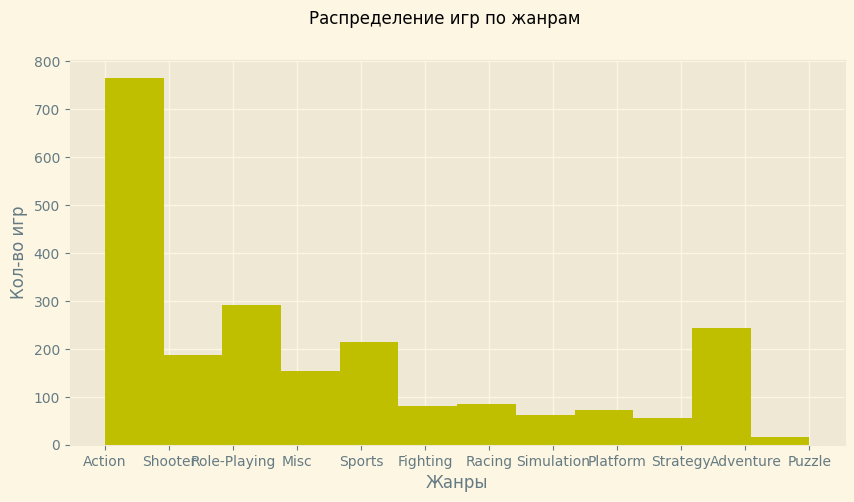

In [38]:
fig, axes = plt.subplots(1,figsize=(10,5))
axes.hist(current_data['genre'], bins=12, color='y')
fig.suptitle('Распределение игр по жанрам');
axes.set_ylabel('Кол-во игр')
axes.set_xlabel('Жанры');

Сильно бросаются в глаза лидеры: больше всего игр в жанре Action, на втором месте Role-Playing, на третьем Adventure.

Теперь построю столбчатую диаграмму, в оси x у которой будут всё те же жанры, а в оси y — средние продажи этих игр. Средние, а не суммарные — как раз потому что количество игр в каждом жанре сильно варьируется, а мне необходимо выяснить, какие жанры лучше продаются, а не в каких выпускается больше игр.

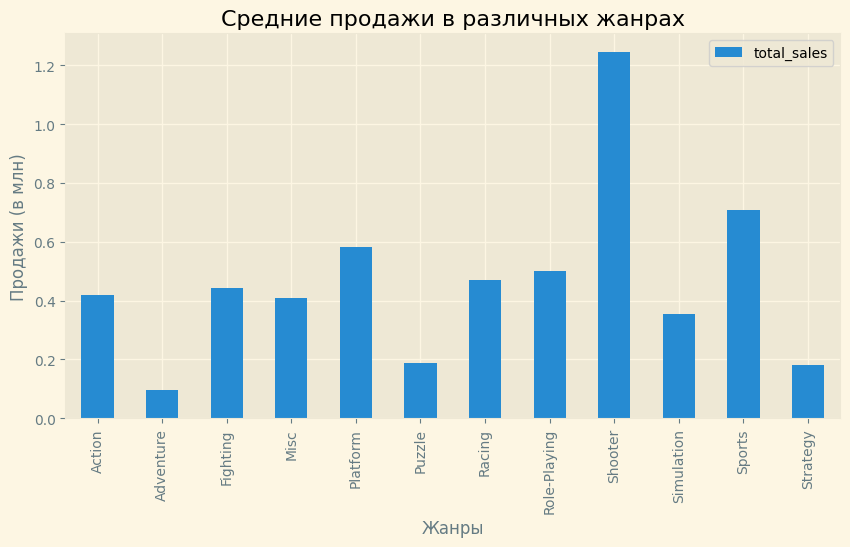

In [39]:
current_data.pivot_table(index='genre', values='total_sales', aggfunc='mean').plot(y='total_sales',
                                                                                   kind='bar',
                                                                                   grid=True,
                                                                                   title='Средние продажи в различных жанрах',
                                                                                   xlabel='Жанры',
                                                                                   ylabel='Продажи (в млн)',
                                                                                  figsize=(10,5));

По диаграмме выше отчётливо видно, что лучше всего в среднем продаются шутеры, на втором месте платформеры, на третьем спортивнные симуляторы. Совершенно иной список, в сравнении с предыдущим. Т.е. продаваемость игр не зависит от их количества.

### Промежуточный вывод

В разделе "Исследовательский анализ данных" я изучала отдельные параметры и их влияние друг на друга. В итоге, можно выделить следующие закономерности:

- До 90-х игр выпускалось совсем мало. Далее. есть несколько резких всплесков в количестве выпускаемых игр: в 1995, 2002 и с 2005 по 2008. После пика в 2008-09, идёт резкое падение, но после 2015 вновь идёт резкая тенденция в рост;
- Срок жизни платформы зависит от её популярности: платформы с бОльшим числом выпущенных игр в среднем живут дольше, чем с меньшим;
- С точки зрения прогнозирования для 2017 года, актуальным периодом можно назвать с 2005 по 2016;
- Платформы PS4, 3DS, XOne, WiiU, PC, PSV — наиболее перспективные в 2017-м;
- В каждой платформе можно сказать, что большинство игр не имеют продаж больше 1-2 миллионов. Также на каждой из них существуют свои лидеры, которые покупают во много раз чаще, чем абсолютное большинство — но их меньше одного процента от общего числа;
- Отзывы пользователей не оказывают практически никакого влияния на покупаемость игры, скорее всего потому что для выставления оценки необходимо сперва купить игру. А вот критики могут повлиять на количество продаж, пусть корреляция тут и не считается сильной;
- Самые покупаемые жанры — это шутер, платформер и спортивный симулятор. При этом, следует отметить что рейтинг самых часто встречаемых жанров и жанров с самыми высокими средними продажами отличаются.

## Портрет пользователя по регионам

В данном разделе я буду составлять портрет пользователя для каждого из представленных регионов: Северная Америка, Европа и Япония.

### Топ-5 самых популярных платформ

Составлю рейтинг из пяти самых популярных платформ для каждого региона и опишу различия в долях их продаж.

#### Северная америка

Начнём с Северной Америки. Список из самых популярных платформ для этого региона за период от 2005 года выглядит следующим образом:

In [40]:
top_platforms_usa = current_data.pivot_table(index='platform', values='na_sales', aggfunc='sum')
top_platforms_usa = top_platforms_usa.sort_values(by='na_sales', ascending=False)
top_platforms_usa.head()

,na_sales
platform,
PS4,108.739998
XOne,93.120003
X360,81.660004
PS3,63.500000
3DS,38.200001


У меня осталось пять лидирующих платформ: X360, Wii, XOne, PS3 и PS4. Теперь построю круглую диаграмму, которая визуализирует доли, занимаемые ими. Все не вошедшие в этот рейтинг платформы я объединю.

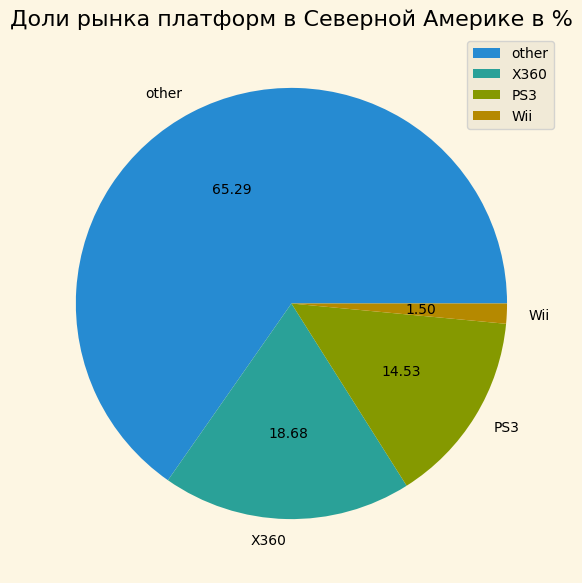

In [41]:
top_usa = ['X360', 'Wii', 'DS', 'PS3', 'PS2']
na_data_for_pie = current_data.query('year_of_release >= 2013')
na_data_for_pie.loc[~na_data_for_pie['platform'].isin(top_usa), 'platform'] = 'other'
top_platforms_usa = na_data_for_pie.pivot_table(index='platform', values='na_sales', aggfunc='sum')
top_platforms_usa = top_platforms_usa.sort_values(by='na_sales', ascending=False)
top_platforms_usa.plot(y='na_sales', kind='pie', figsize=(7, 7), autopct='%.2f',
                      title='Доли рынка платформ в Северной Америке в %', ylabel='');

Как видно по круговой диаграмме выше, доля рынка X360 даже больше, чем у всех не вошедших в топ-5 платформ, скомбинированных вместе. Меньше всего доля у PS2, но это может быть объяснено тем фактом, что мы брали срез данных от 2005 года, как более актуальный для прогнозирования.

#### Европа

Здесь я проделаю всё то же самое, что и с Северной Америкой. Составлю топ-5 игровых платформ и визуализирую их долю рынка.

In [42]:
top_platforms_eu = current_data.pivot_table(index='platform', values='eu_sales', aggfunc='sum')
top_platforms_eu = top_platforms_eu.sort_values(by='eu_sales', ascending=False)
top_platforms_eu.head()

,eu_sales
platform,
PS4,141.089996
PS3,67.809998
XOne,51.590000
X360,42.520000
3DS,30.960001


Список здесь отличается на одну позицию: вместо PS2 в Европе популярной стала PS4. Нарисуем круговую диаграмму:

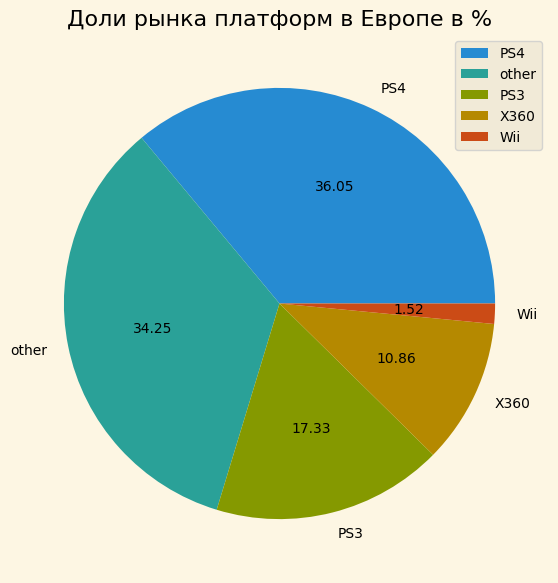

In [43]:
top_eu = ['X360', 'Wii', 'DS', 'PS3', 'PS4']
eu_data_for_pie = current_data.query('year_of_release >= 2013')
eu_data_for_pie.loc[~eu_data_for_pie['platform'].isin(top_eu), 'platform'] = 'other'
top_platforms_eu = eu_data_for_pie.pivot_table(index='platform', values='eu_sales', aggfunc='sum')
top_platforms_eu = top_platforms_eu.sort_values(by='eu_sales', ascending=False)
top_platforms_eu.plot(y='eu_sales', kind='pie', figsize=(7, 7), autopct='%.2f',
                      title='Доли рынка платформ в Европе в %', ylabel='');

Данный график в целом выглядит похоже на предыдущий, но X360 сместилось с первой позиции, а категория other, т.е. платформы, не вошедшие в топ-5, тут занимают свыше четверти от общих продаж в Европе. Видимо, в данном регионе больше преобладает разнообразие платформ.

#### Япония

В отличие от двух предыдущих регионов, здесь у нас представлена отдельная страна. Посмотрим на топ-5 платформ в Японии:

In [44]:
top_platforms_jp = current_data.pivot_table(index='platform', values='jp_sales', aggfunc='sum')
top_platforms_jp = top_platforms_jp.sort_values(by='jp_sales', ascending=False)
top_platforms_jp.head()

,jp_sales
platform,
3DS,67.809998
PS3,23.350000
PSV,18.590000
PS4,15.960000
WiiU,10.880000


Ожидаемо, японцы сильно отличаются от европейских и американских пользователей. Здесь у нас первое место занимает DS, далее 3DS, которого в предыдущих двух топах вовсе не было, как и PSP. Теперь построим круговую диаграмму:

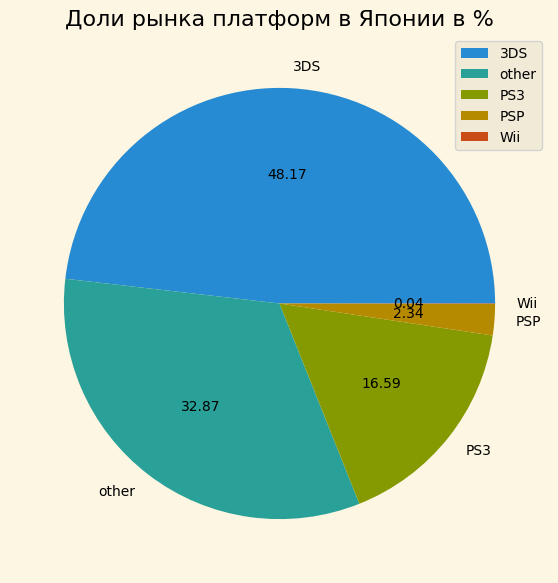

In [45]:
top_jp = ['3DS', 'Wii', 'DS', 'PS3', 'PSP']
jp_data_for_pie = current_data.query('year_of_release >= 2005')
jp_data_for_pie.loc[~jp_data_for_pie['platform'].isin(top_jp), 'platform'] = 'other'
top_platforms_jp = jp_data_for_pie.pivot_table(index='platform', values='jp_sales', aggfunc='sum')
top_platforms_jp = top_platforms_jp.sort_values(by='jp_sales', ascending=False)
top_platforms_jp.plot(y='jp_sales', kind='pie', figsize=(7, 7), autopct='%.2f',
                      title='Доли рынка платформ в Японии в %', ylabel='');

Жители Японии настолько любят Nintendo DS, что игры на неё занимают почти половину рынка в данной стране.

### Топ-5 cамых популярных жанров

В данном подразделе похожим образом, что и в предыдущем, буду исследовать поведение пользователей в трёх регионах. Определю самые популярные жанры среди жителей Северной Америки, Европы и Японии.

#### Северная Америка

Выведу на экран топ-5 самых покупаемых жанров в Северной Америке:

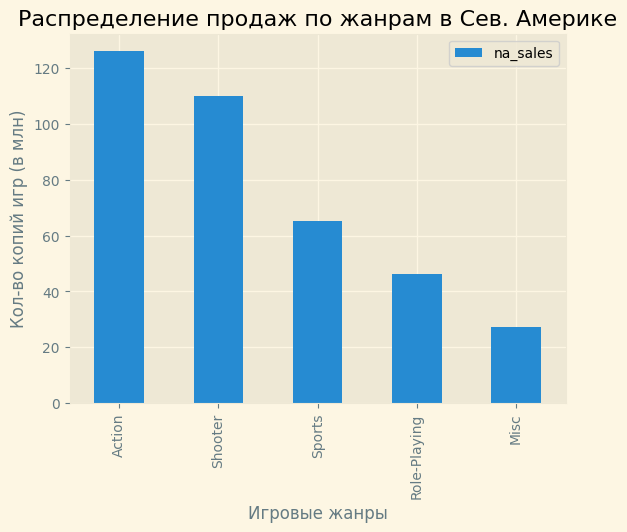

In [46]:
top_genres_na = current_data.pivot_table(index='genre', values='na_sales', aggfunc='sum')
top_genres_na = top_genres_na.sort_values(by='na_sales', ascending=False)
top_genres_na.head().plot(y='na_sales', kind='bar', grid=True,
             title='Распределение продаж по жанрам в Сев. Америке',
             xlabel='Игровые жанры', ylabel='Кол-во копий игр (в млн)');

Больше всего американцы любят экшен-инры. Занявшие пятое место рпг имеют почти втрое меньше продаж.

#### Европа

Топ-5 самых популярных игр в Европе выглядит так:

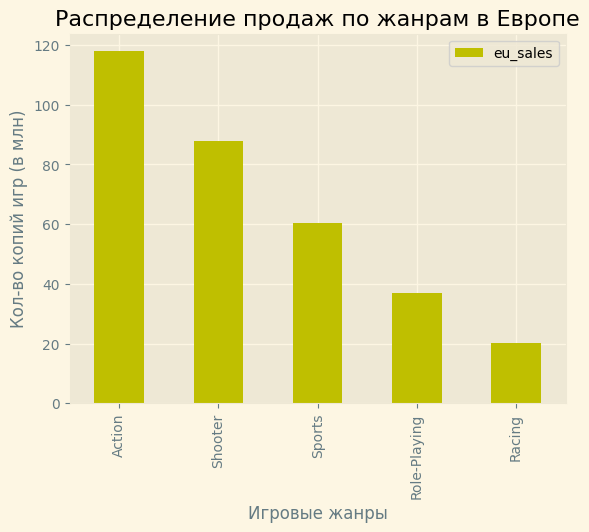

In [47]:
top_genres_eu = current_data.pivot_table(index='genre', values='eu_sales', aggfunc='sum')
top_genres_eu = top_genres_eu.sort_values(by='eu_sales', ascending=False)
top_genres_eu.head().plot(y='eu_sales', kind='bar', grid=True, color='y',
             title='Распределение продаж по жанрам в Европе',
             xlabel='Игровые жанры', ylabel='Кол-во копий игр (в млн)');

Топ-5 в Европе, в целом, выглядит похоже на топ-5 в Америке, за исключением гоночных игр, которые сместили ролевые с пятого места.

#### Япония

Наконец, посмотрим, как от них отличается список популярных жанров в Японии:

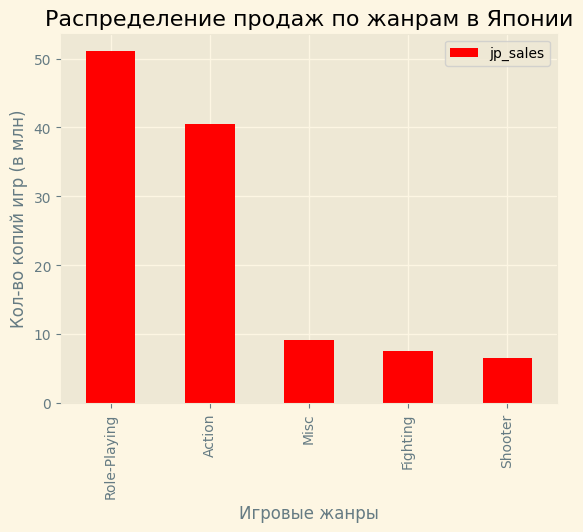

In [48]:
top_genres_jp = current_data.pivot_table(index='genre', values='jp_sales', aggfunc='sum')
top_genres_jp = top_genres_jp.sort_values(by='jp_sales', ascending=False)
top_genres_jp.head().plot(y='jp_sales', kind='bar', grid=True, color='r',
             title='Распределение продаж по жанрам в Японии',
             xlabel='Игровые жанры', ylabel='Кол-во копий игр (в млн)');

Как и следовало ожидать, в стране Восходящего Солнца игроки отдают предпочтение совершенно другим жанрам. Первое место с огромным отрывом у них занимают RPG, сместив экшен, смешанные и спортивные на 2-4 места соответственно. На пятом месте обосновались платформеры.

### Влияние ESRB на продажи

ESRB — Entertainment Software Rating Board — Это международная организация, определяющая возрастной рейтинг игр. В нашем датасете этот рейтинг представлен в колонке rating.

Рейтинги бывают следующими:
- EC — Early Childhood — подходящий для детей контент, 3+
- E — Everyone — контент, подходящий для детей начиная со школьного возраста
- E10+ — контент, рекомендуемый возраст которого от 10 лет
- T — Teen — подрастковый контент, 13+
- M — Mature — контент, не рекомендуемый к просмотру до 17 лет
- Ao — Adults only — контент для взрослых
- RP — Rating Pending — возрастной рейтинг ещё не определён

Посмотрим, оказывает ли он влияние на продаваемость игр в отдельных регионах.

#### Северная Америка

Начну, как и до этого, с Америки. Построю диаграмму, которая отразит среднюю продаваемость игр в этом регионе с разбивкой по ESRB.

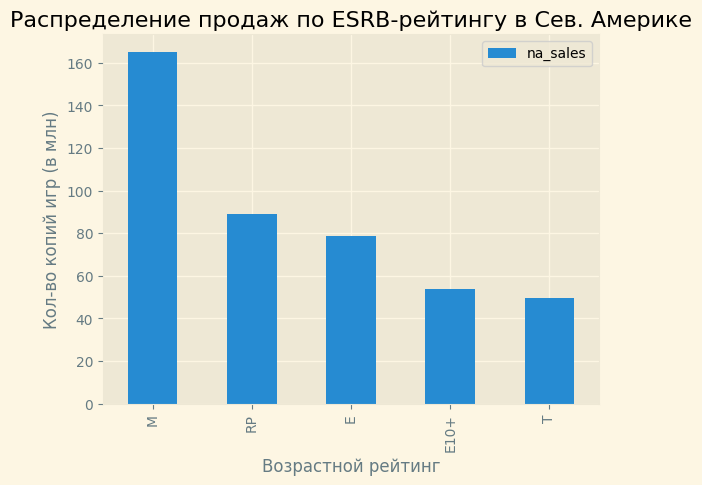

In [49]:
esrb_na = current_data.pivot_table(index='rating', values='na_sales', aggfunc='sum')
esrb_na = esrb_na.sort_values(by='na_sales', ascending=False)
esrb_na.plot(y='na_sales', kind='bar', grid=True,
             title='Распределение продаж по ESRB-рейтингу в Сев. Америке',
             xlabel='Возрастной рейтинг', ylabel='Кол-во копий игр (в млн)');

Как видим, больше всего покупают игр, классифицированных как  "Mature" — т.е. для взрослых, "17+". Далее у нас идут "Everyone", "Everyone 10+", "Teen".

#### Европа

Составлю аналогичный "рейтинг рейтингов" и для Европы:

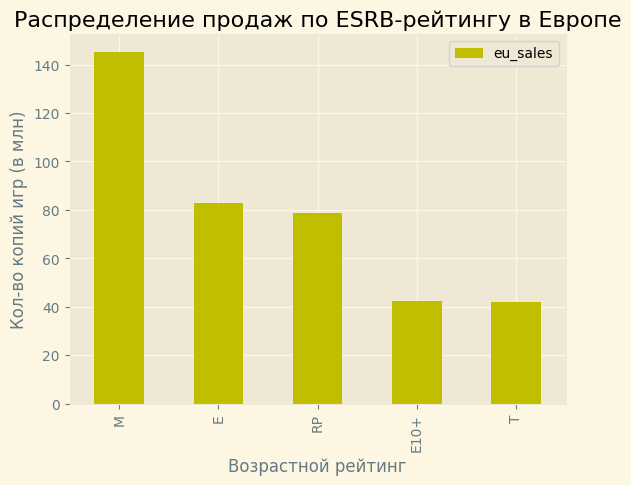

In [50]:
esrb_eu = current_data.pivot_table(index='rating', values='eu_sales', aggfunc='sum')
esrb_eu = esrb_eu.sort_values(by='eu_sales', ascending=False)
esrb_eu.plot(y='eu_sales', kind='bar', grid=True, color='y',
             title='Распределение продаж по ESRB-рейтингу в Европе',
             xlabel='Возрастной рейтинг', ylabel='Кол-во копий игр (в млн)');

Здесь ситуация выглядит похоже, только "Teen" слегка переросло "Everyone 10+"

#### Япония

Теперь посмотрим, как продаются игры различного рейтинга в Японии:

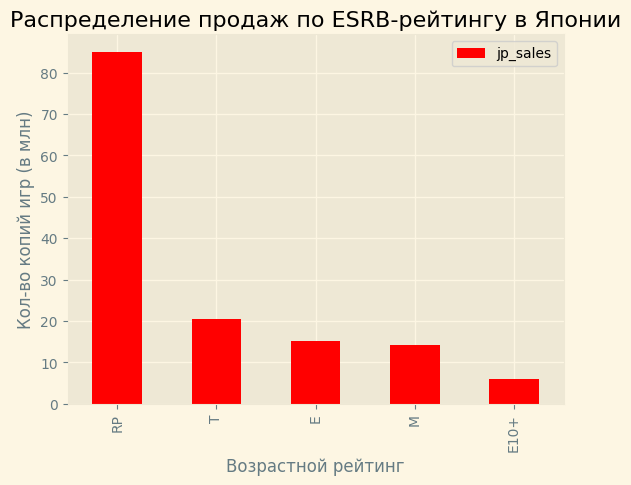

In [51]:
esrb_jp = current_data.pivot_table(index='rating', values='jp_sales', aggfunc='sum')
esrb_jp = esrb_jp.sort_values(by='jp_sales', ascending=False)
esrb_jp.plot(y='jp_sales', kind='bar', grid=True, color='r',
             title='Распределение продаж по ESRB-рейтингу в Японии',
             xlabel='Возрастной рейтинг', ylabel='Кол-во копий игр (в млн)');

Первыми по популярности здесь оказались игры с неопределённым рейтингом. "Teen", т.е. 13+ игры также вышли вперёд, тогда как "Mature" опустились на на четвёртую позицию.

### Промежуточный вывод

В данном разделе я составляла портрет усреднённого пользователя в трёх регионах: Северной Америке, Европе и Японии. Выявилось следующее:
- Самая популярная платформа в Америке — X360, в Европе PS3 (но при этом там наблюдается большее разнообразие в целом), в Японии очень любят DS, которая занимает больше четверти местного рынка;
- Жанровые предпочтения у американцев и европейцев сильно совпадают, и те, и те очень любят Action-игры. Японцы же отдают наибольшее предпочтение RPG;
- По возрастному рейтингу, поведение пользователей в Японии сильно отличается от такового в Америке и Европе.

## Проверка гипотез

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Нулевая гипотеза Н0: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

Альтернативная гипотеза Н1: Средние пользовательские рейтинги платформ Xbox One и PC отличаются.

In [52]:
alpha = 0.05

current_data = current_data.dropna(subset=['user_score'])
results = st.ttest_ind(current_data.loc[current_data['platform'] == 'XOne', 'user_score'],
                       current_data.loc[current_data['platform'] == 'PC', 'user_score'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет отвергаем нулевую гипотезу')

p-значение: 0.14012765210016784
Нет отвергаем нулевую гипотезу


Итак, мы не отвергаем гипотезу о возможном равенстве средних этих оценок. Проверим наверняка:

In [53]:
print(current_data.loc[current_data['platform'] == 'XOne', 'user_score'].mean())
print(current_data.loc[current_data['platform'] == 'PC', 'user_score'].mean())

6.521428
6.2696776


Они, само собой, отличаются. Но не сильно.

### Средние пользовательские рейтинги жанров Action и Sports разные.

Для проверки этой гипотезы я сделаю её обратной — буду проверять, наоборот, что оценки одинаковые, а вот альтернативная гипотеза будет сформулирована как в задании.

Нулевая гипотеза Н0: Средние пользовательские рейтинги жанров Action и Sports одинаковые.

Альтернативная гипотеза Н1: Средние пользовательские рейтинги жанров Action и Sports разные.

In [54]:
alpha = 0.05

results = st.ttest_ind(current_data.loc[current_data['genre'] == 'Action', 'user_score'],
                       current_data.loc[current_data['genre'] == 'Sports', 'user_score'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет отвергаем нулевую гипотезу')

p-значение: 7.102332504860037e-28
Отвергаем нулевую гипотезу


Мы отвергаем нулевую гипотезу в пользу альтернативной. Т.е. в нашей ситуации мы подтверждаем, что оценки пользователей жанров Action и Sports отличаются.

In [55]:
print(current_data.loc[current_data['genre'] == 'Action', 'user_score'].mean())
print(current_data.loc[current_data['genre'] == 'Sports', 'user_score'].mean())

6.8427835
5.238125


Здесь уже разница существенна, так что наша альтернативная гипотеза подтвердилась и на практике.

### Промежуточный вывод

В этом разделе мною были проведены проверки двух гипотез:
- о равенстве средних пользовательских оценок платформ Xbox One и PC;
- о неравенстве средних пользовательских оценок игр в жанрах Action и Sports.

В первом случае, нулевая гипотеза была сформулирована в самом задании. Альтернативная гипотеза является двухсторонней, т.к. под неё подойдёт и вариант, что оценки на Xbox One больше, и вариант, что PC больше.
Во втором случае, пришлось "обратить" гипотезу, поскольку нулевая гипотеза должна быть сформулирована со знаком равенства. Альтернативная гипотеза тут — само предположение из задания, соответственно.

И в том, и в другом случае t-тест был применён, поскольку он максимально не чувствителен к размеру выборки. Метод ttest_ind обозначает метод для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам. Поскольку совокупности "игры на XOne" и "игры на PC" не связаны друг с другом, мы использовали этот метод. То же и с жанрами. В противном случае, был бы применён ttest_rel.

В результате, мы:
- не отвергли первую нулевую гипотезу, т.е. оценки XOne и PC действительно могут быть одинаковыми;
- отвергли вторую нулевую гипотезу, но подтвердили вопрос в задании: оценки Action и Sports отличаются.

## Общий вывод

**В данном аналитическом проекте я провела следующую работу с данными:**
- В разделе "Ознакомление с данными" загрузила датасет и ознакомилась с ним в общих чертах;
- В разделе "Предобработка данных":
    - переписала названия столбцов, чтобы они соответствовали snake_case;
    - Обработала пропущенные значения;
    - Изменила типы данных там, где это было необходимо, а также оптимизировала численные типы данных;
    - Добавила столбец total_sales, отражающий суммарные продажи в регионах.
- В разделе "Исследовательский анализ данных:
    - отобразила распределение игр по годам выпуска;
    - составила топ-10 самых популярных платформ за всё время, определила, как менялась их популярность по годам;
    - вычислила актуальный период, который пригоден для прогнозирования на 2017 год. В дальнейших рассчётах использовался именно актуальный период, а не весь изначальный датасет;
    - определила список платформ, которые потенциально будут прибыльными в 2017 году;
    - построила boxplot ("ящик с усами") и сделала некоторые выводы на его основе о потенциально прибыльных платформах;
    - определила, какое влияние отзывы пользователей и критиков оказывают на продажи игр;
    - построила распределение игр по жанрам.
- В разделе "Портрет пользователя по регионам" я проводила следующую аналитическую работу над данными о продажах в регионах (Северная Америка, Европа и Япония):
    - составила топ-5 самых популярных платформ в этих регионах;
    - составила топ-5 самых популярных жанров;
    - выявила влияние возрастного рейтинга ESRB на продажи;
- В разделе "Проверка гипотез" я ответила на следующие вопросы:
    - одинаковы ли средние пользовательские оценки платформ XboxOne и PC?
    - отличаются ли средние пользовательские оценки в жанрах Action и Sports?
    
**В процессе этой работы я вывела следующие гипотезы:**

- До 90-х годов игр выпускали в разы меньше, чем после;
- Срок жизни платформы зависит от её популярности: платформы с бОльшим числом выпущенных игр в среднем живут дольше, чем с меньшим;
- Платформы PS4, 3DS, XOne, WiiU, PC, PSV — наиболее перспективные в 2017-м;
- В каждой платформе можно сказать, что большинство игр не имеют продаж больше 1-2 миллионов. Также на каждой из них существуют свои лидеры, которые покупают во много раз чаще, чем абсолютное большинство — но их меньше одного процента от общего числа;
- Отзывы пользователей не оказывают практически никакого влияния на покупаемость игры, скорее всего потому что для выставления оценки необходимо сперва купить игру. А вот критики могут повлиять на количество продаж, пусть корреляция тут и не считается сильной;
- Самые покупаемые жанры — это шутер, платформер и спортивный симулятор. При этом, следует отметить что рейтинг самых часто встречаемых жанров и жанров с самыми высокими средними продажами отличаются.
- Самая популярная платформа в Америке — X360, в Европе PS3, в Японии — DS;
- Американцы и европейцы очень любят Action-игры. Японцы предпочитают RPG;
- По возрастному рейтингу, американцы и европейцы чаще всего покупают Mature, затем Everyone, Everyone10+, Teen и реже всего — Early Childhood. Японцы больше всего покупают Everyone, Teen, Mature и затем Everyone10+. Early Childhood у них практически не покупают.

**Рекомендации для бизнеса:**

- Наиболее перспективными платформами я бы назвала PS4 и Xbox One;
- В Северной Америке покупают больше всего игр;
- Самый частый возрастной рейтинг — это M ("Mature");
- Самый продаваемый жанр в мире — шутеры, в Америке — экшен-игры, но шутеры там на втором месте в популярности;
- Оценки пользователей влияния практически не оказывают, но на оценки критиков смотреть стоит.